# Forecasting of daily River Discharge (RD) based on previous River Discharge

### Import of libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### Load information from csv


In [2]:
data=pd.read_csv("RD_data/RD_AntuaR_pg.csv")

data.head()

,Date,RD,Temp,Prec
0,01/01/1985,3.39,8.1,0.0
1,02/01/1985,3.28,8.1,0.0
2,03/01/1985,3.30,8.1,0.0
3,04/01/1985,4.14,8.1,7.9
4,05/01/1985,8.98,8.1,38.1


### Ploting data

Text(0, 0.5, 'River discharge ')

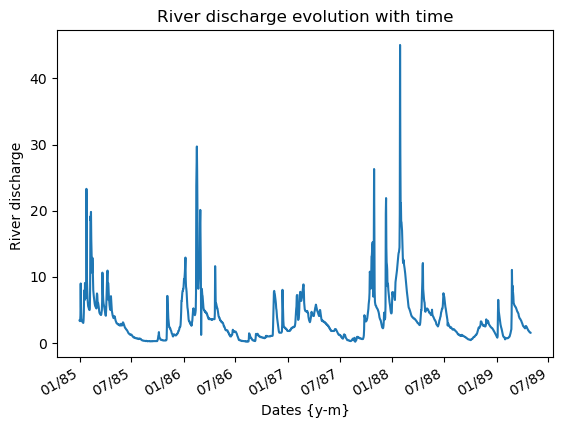

In [3]:
dataV = data.values
dates = dataV[:,0]
plotDates = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dates]
rd = dataV[:,1]
temp = dataV[:,2]
prec = dataV[:,3]

plt.plot(plotDates,rd)
plt.xlabel("Dates {y-m}")
plt.title("River discharge evolution with time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("River discharge ")


Text(0, 0.5, 'Avg monthly emperature')

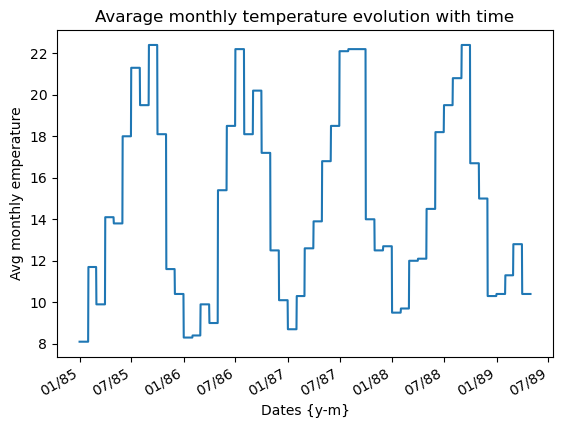

In [4]:
plt.plot(plotDates,temp)
plt.xlabel("Dates {y-m}")
plt.title("Avarage monthly temperature evolution with time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("Avg monthly emperature")

Text(0, 0.5, 'Precipitation')

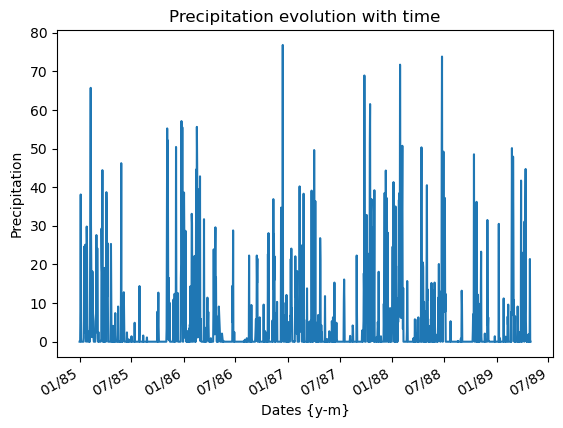

In [5]:
plt.plot(plotDates,prec)
plt.xlabel("Dates {y-m}")
plt.title("Precipitation evolution with time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("Precipitation")

### Normalization

In [6]:
def featureNormalization(X):
    mean= np.mean(X,axis=0)
    std= np.std(X,axis=0)
    X_norm = (X - mean)/std
    
    return X_norm , mean , std

## Using library


In [7]:
rdT = np.array([rd[1:-1],rd[0:-2]])
rdT = rdT.transpose()
print(rdT.shape)
y = rd[2:]
print(y.shape)

rdTests = rdT[:315]
rdVal = rdT[315:631]
rdTrain = rdT[631:]
yTests = y[:315]
yVal = y[315:631]
yTrain = y[631:]


reg = linear_model.Ridge(alpha=1)
reg.fit(rdTrain,yTrain)


predict = reg.predict(rdTests)

#ridge_reg = linear_model.Ridge(alpha=.5)
#ridge_reg.fit(rdT,y)

#thetaRidge = ridge_reg.coef_

(1579, 2)
(1579,)


## Testing alpha

R-squared (R2): 0.8270143636857354


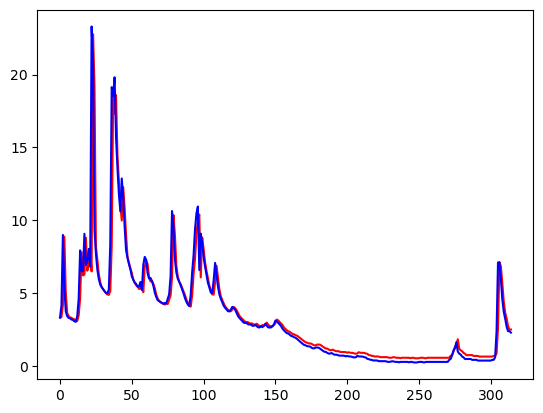

In [8]:
plt.plot(predict,'r')
plt.plot(yTests,'b')
r2 = r2_score(yTests, predict)
print("R-squared (R2):", r2)



In [9]:

p2 = np.dot(rdT,thetaRidge)
plt.scatter(plotDates[2:], y, color="black")
plt.plot(plotDates[2:], p2, color="yellow", linewidth=3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()


NameError: name 'thetaRidge' is not defined